# Spike Train Analysis: Exercise 1 - Cross-Correlations 

This notebook covers the following topics:

* Pairwise correlations and the cross-correlation histogram
* Evaluation of statistical significance for peaks of a cross-correlation histogram
* Surrogate-based methods of p-value estimation; surrogate types and their features

## Suggested data sets
In this notebook you will analyse data from pairs of simultaneously recorded spike trains, contained in the folder `'./data/'`.
The following pairs are suitable for the pairwise analysis: [`Data28`, `Data29`],[`Data12`, `Data13`], [`Data14`, `Data15`], [`Data20`, `Data21`], [`Data21`, `Data22`], [`Data23`, `Data24`].

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import quantities as pq
import elephant.spike_train_correlation as corr
import elephant.spike_train_surrogates as surr
import elephant.statistics as stats
import elephant.conversion as conv

%matplotlib inline

# Task 1: Cross-Correlations

## 1.1 Raw cross-correlation histogram
The cross-correlation histogram (CCH) is a standard tool to analyse fine-temporal correlations between two (simultaneously recorded) spike trains.
The CCH between a reference spike train $x$ and a target spike train $y$ estimates, at each time lag $\tau$, the tendency of $y$ to spike at time $\tau$ after a spike in $x$.
* Analyse simultaneously recorded spike trains (i.e., [Data28, Data29], [Data12, Data13], [Data14, Data15], [Data20, Data21], [Data21, Data22], [Data23, Data24]) for possible temporal correlations by use of the CCH (see `corr.cross_correlation_histogram()`).
* Study the ground truth of each individual dataset by the measure we already learnt, e.g. PSTH, ISI distribution, etc. 
* Describe the features of the CCHs, and what they mean. Where do the modulations of the entries in the CCH come from, e.g., a bump in the middle? Can you distinguish contributions due to firing rates and fine-temporal correlation?
* What are the differences between the CCHs of the data sets? Are all pairs correlated?

In [2]:
# Analysis parameters
data_id1, data_id2 = 20, 21
w = 2 * pq.ms  # binsize for CCH
maxlag = 200 * pq.ms  # maximum correlation lag

# Load the data
data1 = np.load(f'./data/Data{data_id1}.npy', allow_pickle=True, encoding='latin1')
data2 = np.load(f'./data/Data{data_id2}.npy', allow_pickle=True, encoding='latin1')
spike_trains1 = data1.item()['st']  # List of neo.SpikeTrain objects; one object per trial
spike_trains2 = data2.item()['st']

In [3]:
import elephant
elephant.__version__

'1.1.0'

In [19]:
type(spike_trains1[0])

neo.core.spiketrain.SpikeTrain

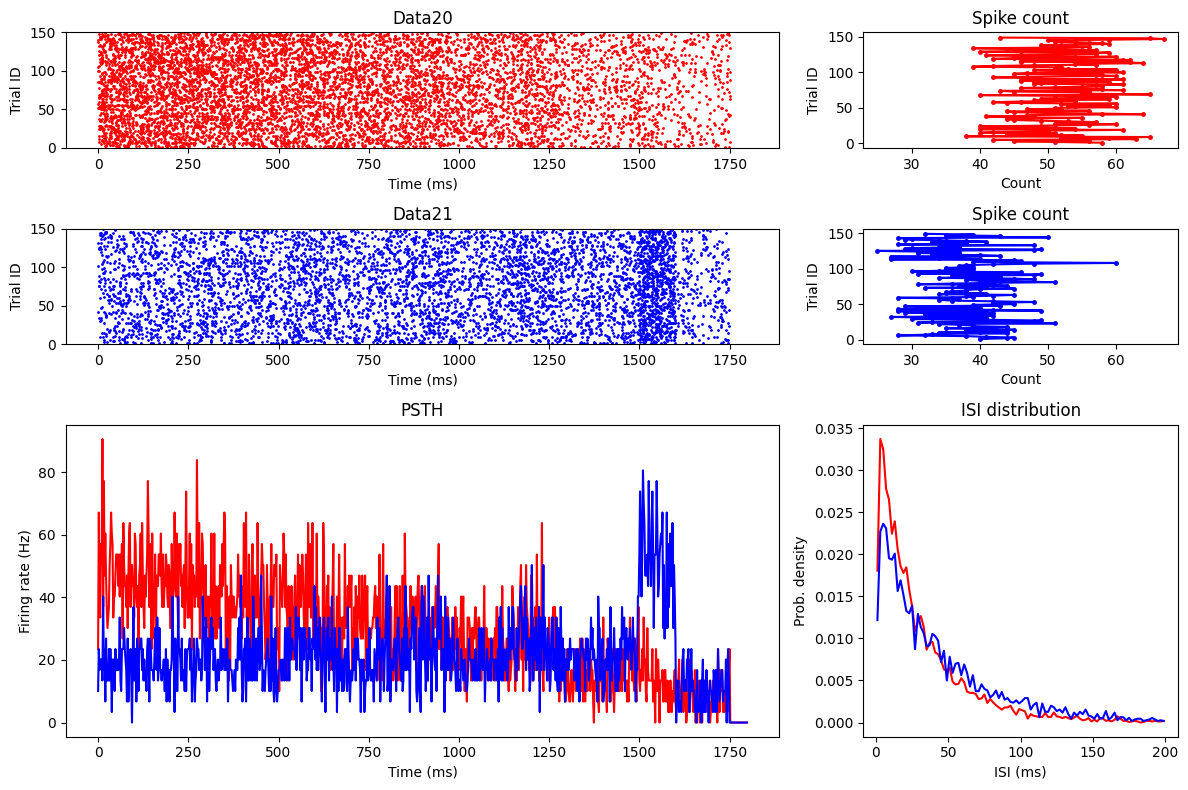

In [4]:
# Plot the data summary

# Compute PSTH
psth1 = stats.time_histogram(spike_trains1, binsize=w, output='rate')
psth2 = stats.time_histogram(spike_trains2, binsize=w, output='rate')

# Compute ISI distribution
isis1 = np.concatenate([stats.isi(st).rescale('ms').magnitude for st in spike_trains1])
isis2 = np.concatenate([stats.isi(st).rescale('ms').magnitude for st in spike_trains2])
isi_bin_edges = np.arange(0, (maxlag + w/2).rescale('ms').magnitude, w.rescale('ms').magnitude)
isi_dist1, _ = np.histogram(isis1, bins=isi_bin_edges, density=True)
isi_dist2, _ = np.histogram(isis2, bins=isi_bin_edges, density=True)
isi_bin_pos = (isi_bin_edges[1:] + isi_bin_edges[:-1]) / 2

# Plot the results
fig1 = plt.figure(figsize=(12, 8))
num_row, num_col = 4, 3

ax_raster1 = plt.subplot2grid((num_row, num_col), (0, 0), rowspan=1, colspan=2)
ax_raster1.set_title(f"Data{data_id1}")
ax_raster1.set_xlabel("Time (ms)")
ax_raster1.set_ylabel("Trial ID")
for i, st in enumerate(spike_trains1):
    ax_raster1.plot(st.rescale('ms').magnitude, [i + 1] * len(st), '.', ms=2, color='r')
ax_raster1.set_ylim(0, len(spike_trains1) + 1)

ax_raster2 = plt.subplot2grid((num_row, num_col), (1, 0), rowspan=1, colspan=2, sharex=ax_raster1)
ax_raster2.set_title(f"Data{data_id2}")
ax_raster2.set_xlabel("Time (ms)")
ax_raster2.set_ylabel("Trial ID")
for i, st in enumerate(spike_trains2):
    ax_raster2.plot(st.rescale('ms').magnitude, [i + 1] * len(st), '.', ms=2, color='b')
ax_raster2.set_ylim(0, len(spike_trains2) + 1)

ax_psth = plt.subplot2grid((num_row, num_col), (2, 0), rowspan=2, colspan=2, sharex=ax_raster1)
ax_psth.set_title("PSTH")
ax_psth.set_xlabel("Time (ms)")
ax_psth.set_ylabel("Firing rate (Hz)")
ax_psth.plot(psth1.times.rescale('ms'), psth1.rescale('Hz'), color='r')
ax_psth.plot(psth2.times.rescale('ms'), psth2.rescale('Hz'), color='b')

ax_count1 = plt.subplot2grid((num_row, num_col), (0, 2), rowspan=1, colspan=1)
ax_count1.set_title("Spike count")
ax_count1.set_xlabel("Count")
ax_count1.set_ylabel("Trial ID")
ax_count1.plot([len(st) for st in spike_trains1], range(1, len(spike_trains1)+1), '.-', ms=5, color='r')

ax_count2 = plt.subplot2grid((num_row, num_col), (1, 2), rowspan=1, colspan=1, sharex=ax_count1)
ax_count2.set_title("Spike count")
ax_count2.set_xlabel("Count")
ax_count2.set_ylabel("Trial ID")
ax_count2.plot([len(st) for st in spike_trains2], range(1, len(spike_trains2)+1), '.-', ms=5, color='b')

ax_isi = plt.subplot2grid((num_row, num_col), (2, 2), rowspan=2, colspan=1)
ax_isi.set_title("ISI distribution")
ax_isi.set_xlabel("ISI (ms)")
ax_isi.set_ylabel("Prob. density")
ax_isi.plot(isi_bin_pos, isi_dist1, color='r')
ax_isi.plot(isi_bin_pos, isi_dist2, color='b')

fig1.tight_layout()

In [15]:
st1_binned

BinnedSpikeTrain(t_start=0.0 ms, t_stop=1800.0 ms, bin_size=2.0 ms; shape=(1, 900), format=csr_matrix)

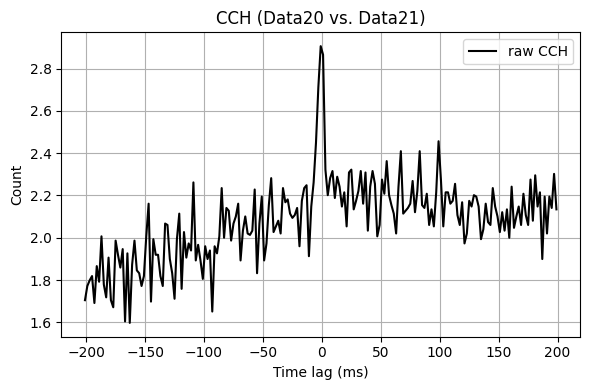

In [5]:
# Compute the CCHs across trials
num_lags = int((maxlag / w).magnitude)
cchs = []
for st1, st2 in zip(spike_trains1, spike_trains2):
    st1_binned = conv.BinnedSpikeTrain(st1, w)
    st2_binned = conv.BinnedSpikeTrain(st2, w)
    cch, lags = corr.cross_correlation_histogram(st1_binned, st2_binned, window=[-num_lags, num_lags])
    cchs.append(cch)

# Average the CCHs over trials (keeping cch_orig to be a neo.AnalogSignal object)
cch_orig = cchs[0]
for cch in cchs[1:]:
    cch_orig += cch
cch_orig /= len(cchs)

# Plot the result
fig2, ax_cch = plt.subplots(1, 1, figsize=(6, 4))
ax_cch.set_title(f"CCH (Data{data_id1} vs. Data{data_id2})")
ax_cch.set_xlabel("Time lag (ms)")
ax_cch.set_ylabel("Count")
ax_cch.plot(cch_orig.times.rescale('ms'), cch_orig, 'k-', label='raw CCH')
ax_cch.legend()
ax_cch.grid()
fig2.tight_layout()

plt.show()

## 1.2 Correlations above chance level?

Deriving the statistical significance of observed correlations is crutial for assessing whether two spike trains are really correlated, or more rigorously, whether the null hypothesis of independence can be rejected. However, it is typically not feasible to assess analytically the statistical significance of spike train correlation. An alternative powerful approach is the surrogate-based estimation of statistical significance. A surrogate is created by randomizing the original data to destroy specific statistical features of the data (here, precise correlation) while keeping other relevant features (e.g. firing rates and/or ISI distribution). 

* Generate a large number of (e.g. 100) surrogate datasets by spike dithering (see `surr.dithering()`), and compute a CCH for each surrogate
* Compare the surrogate CCH with the CCH of the original data: is the latter significant?
* Play with the dither parameter: what is an optimal choice? Why? (Compare to the firing rates of the surrogate data...) 

In [6]:
# Analysis parameters
surr_method = 'dither_spike_train'
dither_width = 8 * pq.ms
n_surr = 100

# For each data set, generate n_surr surrogates of each trial via spike dithering
surr1_dith = [surr.surrogates(st, n=n_surr, surr_method=surr_method, dt=dither_width) for st in spike_trains1]
surr2_dith = [surr.surrogates(st, n=n_surr, surr_method=surr_method, dt=dither_width) for st in spike_trains2]

# Compute n_surr CCHs, one per pair of surrogate data sets

def compute_surrogate_cchs(surr1, surr2, n_surr, w, maxlag):
    num_lags = int((maxlag / w).magnitude)
    len_cch = 2 * num_lags + 1
    cchs_surr = np.zeros((n_surr, len_cch))
    for surr_id in range(n_surr):
        sts1 = [st[surr_id] for st in surr1]
        sts2 = [st[surr_id] for st in surr2]
        for st1, st2 in zip(sts1, sts2):
            st1_binned = conv.BinnedSpikeTrain(st1, w)
            st2_binned = conv.BinnedSpikeTrain(st2, w)
            cchs_surr[surr_id] += corr.cross_correlation_histogram(st1_binned, st2_binned, window=(-num_lags, num_lags))[0].reshape(len_cch)
        cchs_surr[surr_id] /= len(sts1)
    return cchs_surr

cchs_dith = compute_surrogate_cchs(surr1_dith, surr2_dith, n_surr, w, maxlag)
    
# Compute the mean CCH, and the threshold for significance
cch_mean_dith = cchs_dith.mean(axis=0)
cch_threshold_dith = np.quantile(cchs_dith, 0.95, axis=0)

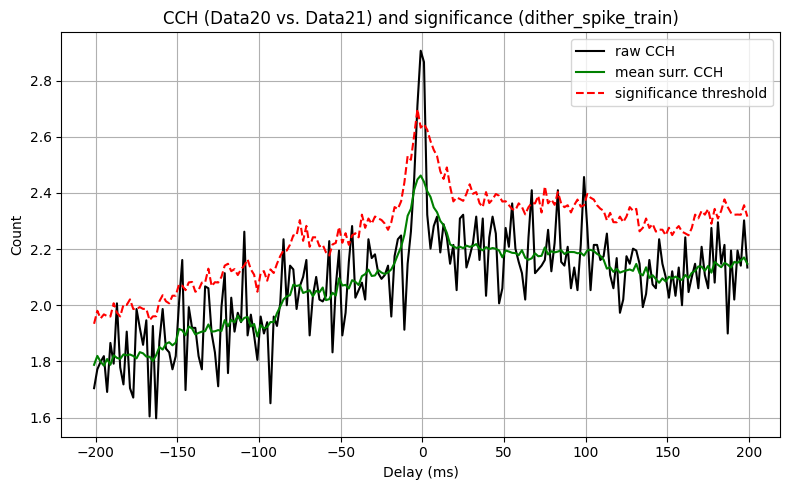

In [7]:
# Plot the original CCH, the mean surrogate CCH, and the significance threshold

def plot_cch(data_id1, data_id2, surr_method, cch, surr_cch_mean, cch_threshold, figsize=(8, 5)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(cch.times.magnitude, cch.magnitude, 'k-', label="raw CCH")
    ax.plot(cch.times.magnitude, surr_cch_mean, 'g-', label="mean surr. CCH")
    ax.plot(cch.times.magnitude, cch_threshold, 'r--', label="significance threshold")
    ax.set_title(f"CCH (Data{data_id1} vs. Data{data_id2}) and significance ({surr_method})")
    ax.set_xlabel("Delay (ms)")
    ax.set_ylabel("Count")
    ax.legend()
    ax.grid()
    fig.tight_layout()
    plt.show()

plot_cch(data_id1, data_id2, surr_method, cch_orig, cch_mean_dith, cch_threshold_dith)

## 1.3 Comparison of surrogate types

Spike dithering is not the only way to generate surrogate data. Many other methods exist, which destroy/keep different features of the original data (for a comparison study see Louis et al., 2010).

Among these methods, a simple approach is *spike time randomisation*, which keeps the number of spikes (and therefore the average firing rate) of the original spike trains, but places each spike randomly within the considered time period.

* Generate surrogates of the same spike trains as before by spike time randomisation (see `surr.spike_time_rand()`)
* Compute the CCHs of spike time randomisation surrogates, and plot the result. How does it differ from surrogates by dithering?
* Discuss which features each method preserves, and what are pros and cons of each.
* On which data sets do they work fine, on which not? Why?

In [8]:
# Analysis parameters
surr_method = 'randomise_spikes'
n_surr = 100

# Generate surrogates by spike time randomisation (str)
surr1_str = [surr.surrogates(st, n=n_surr, surr_method=surr_method) for st in spike_trains1]
surr2_str = [surr.surrogates(st, n=n_surr, surr_method=surr_method) for st in spike_trains2]

# Compute n_surr CCHs, one per pair of surrogate data sets
cchs_str = compute_surrogate_cchs(surr1_str, surr2_str, n_surr, w, maxlag)

# Compute the mean CCH, and the threshold for significance
cch_mean_str = cchs_str.mean(axis=0)
cch_threshold_str = np.quantile(cchs_str, 0.95, axis=0)

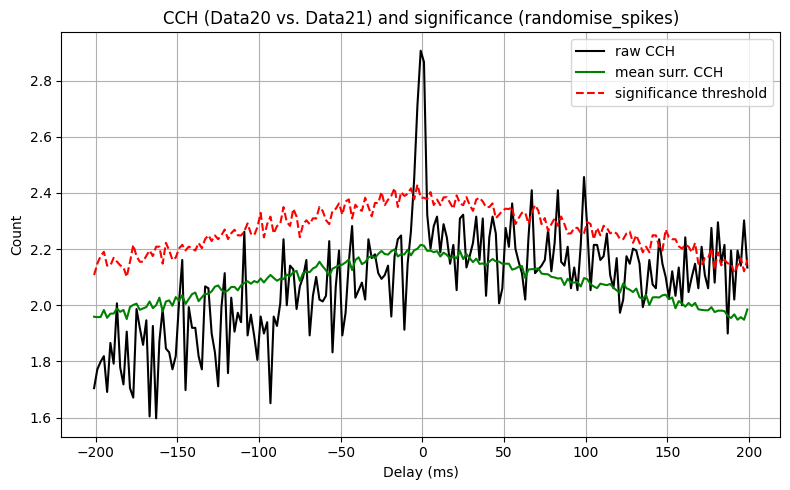

In [9]:
# Plot the original CCH, the mean surrogate CCH, and the significance threshold
plot_cch(data_id1, data_id2, surr_method, cch_orig, cch_mean_str, cch_threshold_str)

A simple alternative technique to generate surrogates is trial shuffling. Each surrogate corresponds to a random shuffle of the trial indices. The philosophy behind is that the processing in the different trials is identical and therefore spike trains of the different neurons from different trials are cross-correlated, but for the testing one only wants to destroy potential spike correlation. Thus we compute in the surrogate the CCH for randomly selected trials of each neuron and compute the average CCH.  
* Generate the surrogate data by trial shuffling with different number of shuffles and compute the surrogate CCH.
* Compare the surrogate CCH with the CCH of the original data: is the latter significant?
* Discuss the results. What feature of the data has been destroyed/conserved with this method?

In [10]:
# Analysis parameters
n_surr = 100

# Generate surrogate by trial shuffling
num_trials = len(spike_trains1)
surr1_shf = [[] for _ in range(num_trials)]
surr2_shf = [[] for _ in range(num_trials)]
for j in range(n_surr):
    random_idx = np.arange(num_trials, dtype=int)
    np.random.shuffle(random_idx)
    for i, j in enumerate(random_idx):
        surr1_shf[i].append(spike_trains1[j])  # shuffle trials only for spike_trains1
        surr2_shf[i].append(spike_trains2[i])  # spike_trains2 is just copied with the correct trial order

# Compute n_surr CCHs, one per pair of surrogate data sets
cchs_shf = compute_surrogate_cchs(surr1_shf, surr2_shf, n_surr, w, maxlag)

# Compute the mean CCH, and the threshold for significance
cch_mean_shf = cchs_shf.mean(axis=0)
cch_threshold_shf = np.quantile(cchs_shf, 0.95, axis=0)

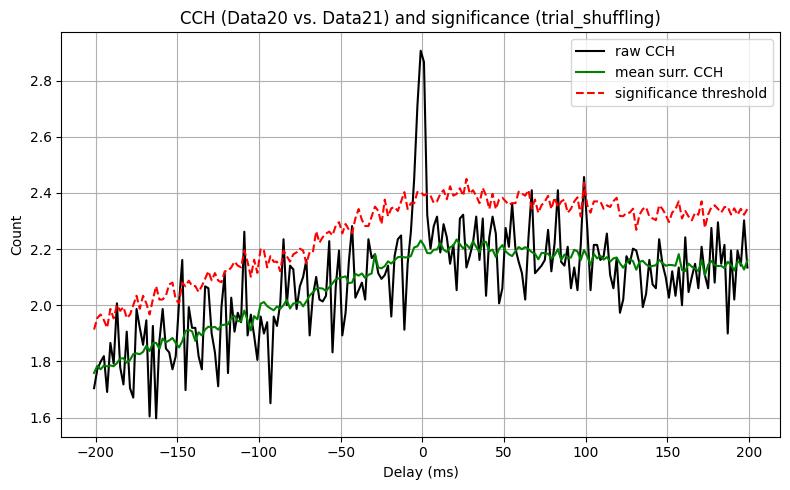

In [11]:
# Plot the original CCH, the average from surrogates and the significance threshold
plot_cch(data_id1, data_id2, "trial_shuffling", cch_orig, cch_mean_shf, cch_threshold_shf)